## Figure 3A-B

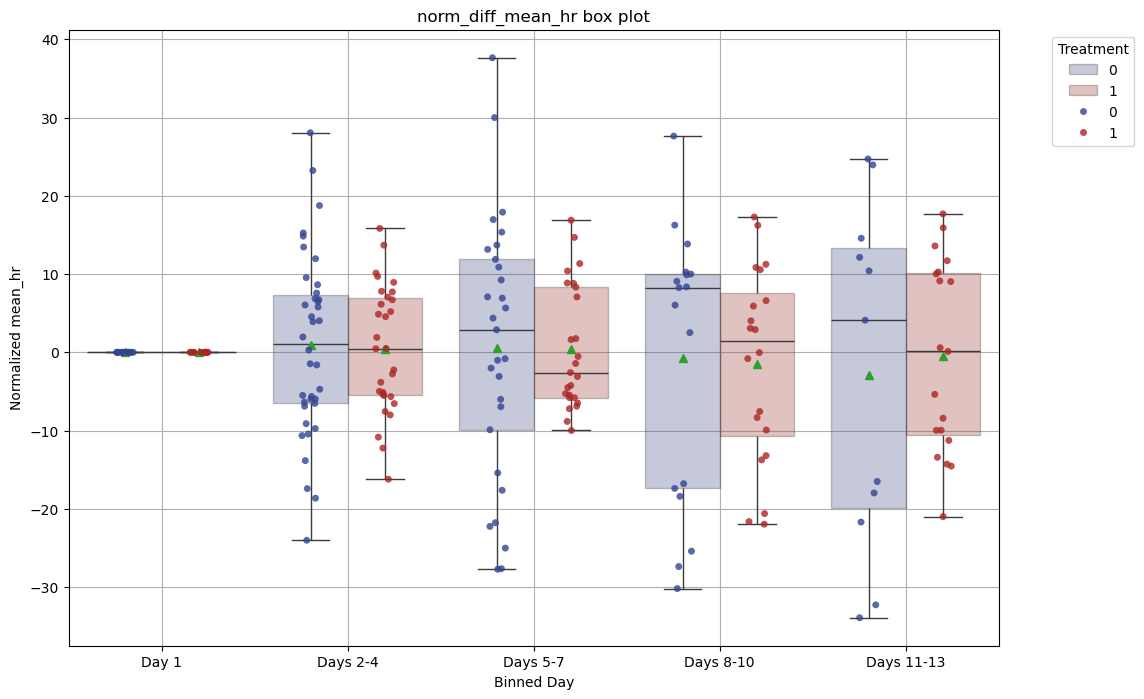

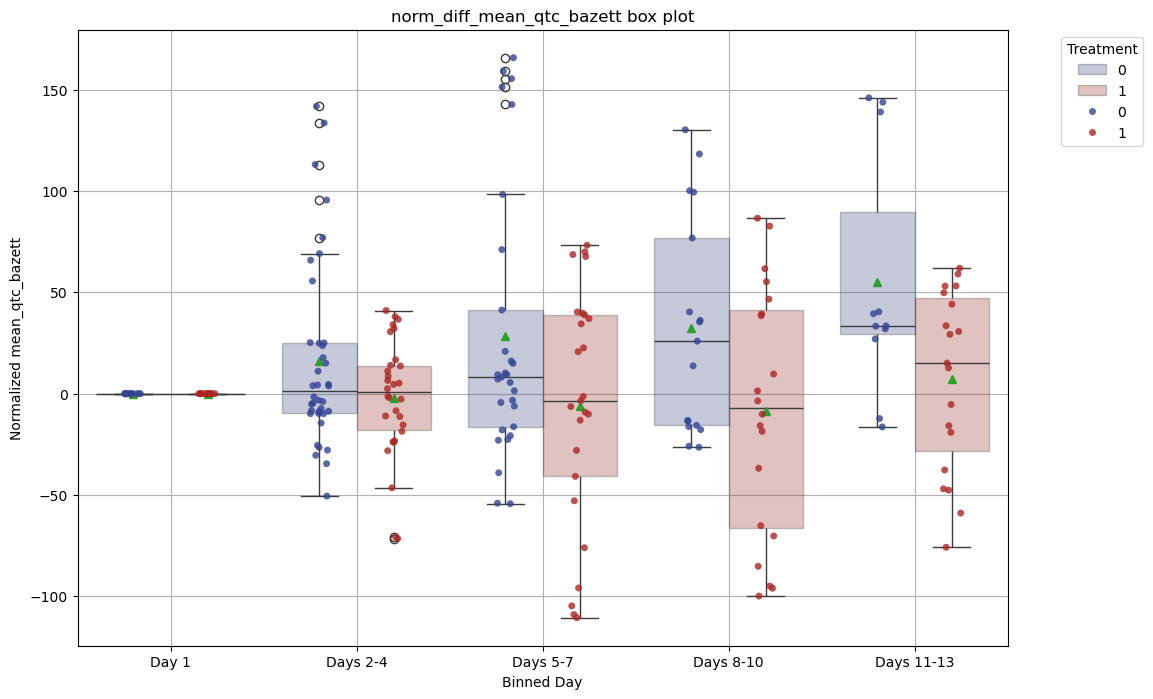

In [7]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import logging
df_hrv = pd.read_csv('df_hrv_sum.csv', index_col=0)
# define helper function for normalization and day binning
def find_valid_baseline(df, subj, feature):
    # Define the order of days to check for a valid baseline
    days_to_check = [1] + [day for day in range(-1, 3) if day != 1]  # Starts with day 1, then checks days -1, 0, 2, 
    
    for day in days_to_check:
        baseline = df[(df['subj'] == subj) & (df['research_day'] == day)][feature].values
        if len(baseline) > 0 and not np.isnan(baseline[0]):
            # print(f"use day {day} as baseline Subject {subj} - {feature}")
            return baseline[0]
    return None
def assign_3_day_bin(day):
    if day == 1:
        return 'Day 1'
    else:
        bin_num = ((day - 2) // 3) + 1
        start_day = 3 * bin_num - 1
        end_day = start_day + 2
        return f'Days {start_day}-{end_day}'

# main script
features_of_interest = ['mean_hr', 'mean_qtc_bazett']
for feature in features_of_interest:
    for subj in df_hrv['subj'].unique():
        baseline = find_valid_baseline(df_hrv, subj, feature)
        if baseline is not None:
            df_hrv.loc[df_hrv['subj'] == subj, 'norm_diff_' + feature] = \
            df_hrv[df_hrv['subj'] == subj][feature] - baseline
        else:
            pass  


df2plot = df_hrv.copy()
df2plot = df2plot[(df2plot['research_day'] <=13) & (df2plot['research_day'] >=1)]
df2plot['day_bin'] = df2plot['research_day'].apply(assign_3_day_bin)
# set pallete
treatment_color = "#AB2522"
non_treatment_color = "#334493"
hue_order = [0, 1]
palette = {0: non_treatment_color, 1: treatment_color} 

for feature in features_of_interest:
    plt.figure(figsize=(12, 8))
    norm_type = 'norm_diff_'
    sns.boxplot(x='day_bin', y=f'{norm_type}{feature}', hue='treatment', data=df2plot,
                palette=palette, showmeans=True, boxprops=dict(alpha=.3))
    sns.stripplot(x='day_bin', y=f'{norm_type}{feature}', hue='treatment', data=df2plot,
                  hue_order=hue_order, palette=palette, dodge=True, jitter=True, alpha=0.8)
    plt.title(f'{norm_type}{feature} box plot')
    plt.xlabel('Binned Day')
    plt.ylabel('Normalized ' + feature)
    plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True)
    plt.show()

## Figure 3C-D

miss rmssd          0
sdnn           0
pnni_50        0
cvi            0
total_power    0
hfnu           0
mean_hr        0
csi            0
dtype: int64 data


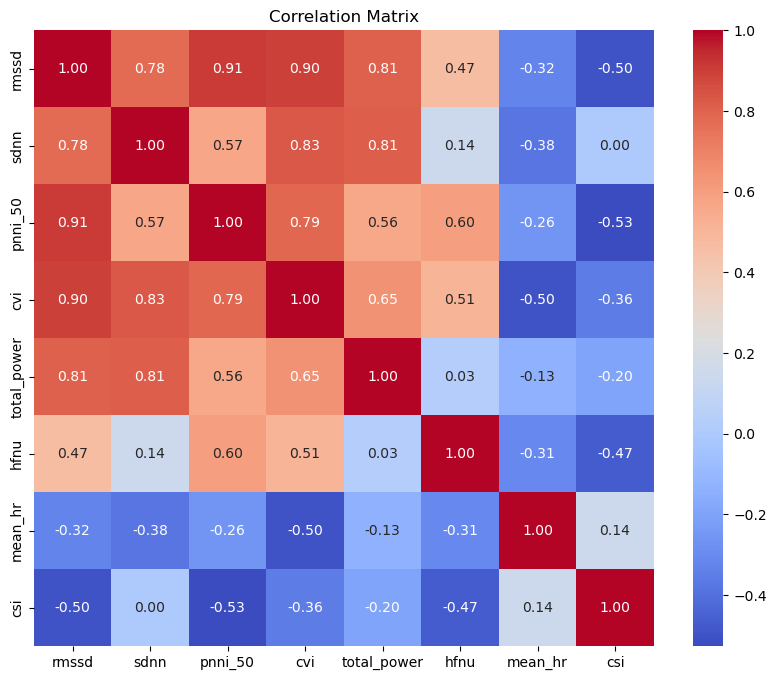

Bartlett’s test p-value: 0.0
KMO test: 0.6734669813213725
[4.61657058 1.46033761 0.97622157 0.53819852 0.19984955 0.15620232
 0.04284578 0.00977408]


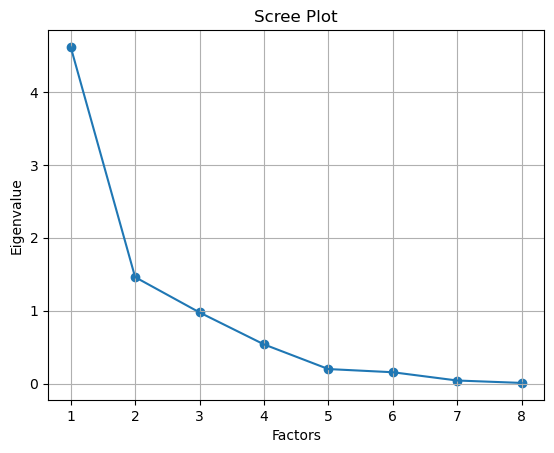

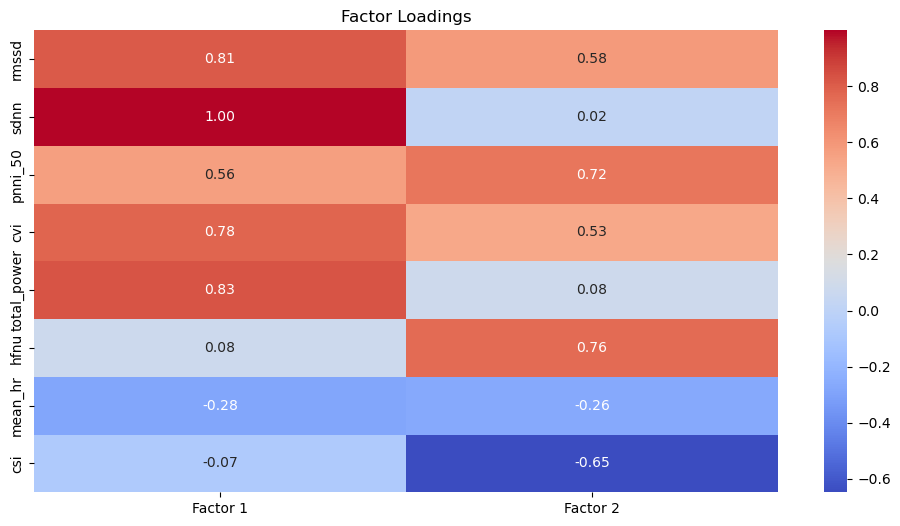

                       Factor 1  Factor 2
Variance               3.357256  2.212089
Proportional Variance  0.419657  0.276511
Cumulative Variance    0.419657  0.696168


In [10]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.preprocessing import StandardScaler
efa_data = df_hrv[['rmssd', 'sdnn', 'pnni_50', 'cvi', 'total_power','hfnu', 'mean_hr','csi']]
measurements = ['rmssd', 'sdnn', 'pnni_50', 'cvi', 'total_power','hfnu', 'mean_hr','csi']
missing_data_count = efa_data.isna().sum()
print(f'miss {missing_data_count} data')
efa_data_imputed = efa_data.fillna(efa_data.mean())
scaler = StandardScaler()
efa_data_imputed[measurements] = scaler.fit_transform(efa_data_imputed[measurements])

# viz corr matrix
corr_matrix = efa_data_imputed.corr()
save_path = '/Users/ganshengtan/Library/CloudStorage/Box-Box/Washu/ECG_VNS/presentation/individual_hrv_over_time_longterm/corr.pdf'
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

chi_square_value, p_value = calculate_bartlett_sphericity(efa_data_imputed)
print('Bartlett’s test p-value:', p_value)
kmo_all, kmo_model = calculate_kmo(efa_data_imputed)
print('KMO test:', kmo_model)

fa = FactorAnalyzer(rotation='varimax')
fa.fit(efa_data_imputed)

ev, v = fa.get_eigenvalues()
print(ev)

plt.scatter(range(1, efa_data_imputed.shape[1]+1), ev)
plt.plot(range(1, efa_data_imputed.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.savefig(save_path)
plt.show()

# we select two factors
fa = FactorAnalyzer(n_factors=2, rotation='varimax')
fa.fit(efa_data_imputed)

loadings = fa.loadings_

loadings_df = pd.DataFrame(loadings, index=efa_data_imputed.columns, columns=['Factor 1', 'Factor 2'])

plt.figure(figsize=(12, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Factor Loadings')
plt.show()

explained_variance = fa.get_factor_variance()

explained_variance_df = pd.DataFrame(explained_variance, index=['Variance', 'Proportional Variance', 'Cumulative Variance'],
                                     columns=['Factor 1', 'Factor 2'])

print(explained_variance_df)

# add factor score in df_hrv
loadings_factor1 = {}
loadings_factor2 = {}

for i_measurement in range(len(measurements)):
    measurement = measurements[i_measurement]
    loadings_factor1[measurement] = loadings[i_measurement, 0]
    loadings_factor2[measurement] = loadings[i_measurement, 1]
    
efa_data_imputed['factor1_score'] = 0.0
efa_data_imputed['factor2_score'] = 0.0

for index, row in efa_data_imputed.iterrows():
    factor1_score = sum(row[measurement] * loadings_factor1[measurement] for measurement in measurements)
    factor2_score = sum(row[measurement] * loadings_factor2[measurement] for measurement in measurements)

    efa_data_imputed.at[index, 'factor1_score'] = factor1_score
    efa_data_imputed.at[index, 'factor2_score'] = factor2_score

# Adding factor scores to the original dataframe
df_hrv['overall_hrv'] = efa_data_imputed['factor1_score']
df_hrv['parasympathetic'] = efa_data_imputed['factor2_score']


## Figure 3 E-F

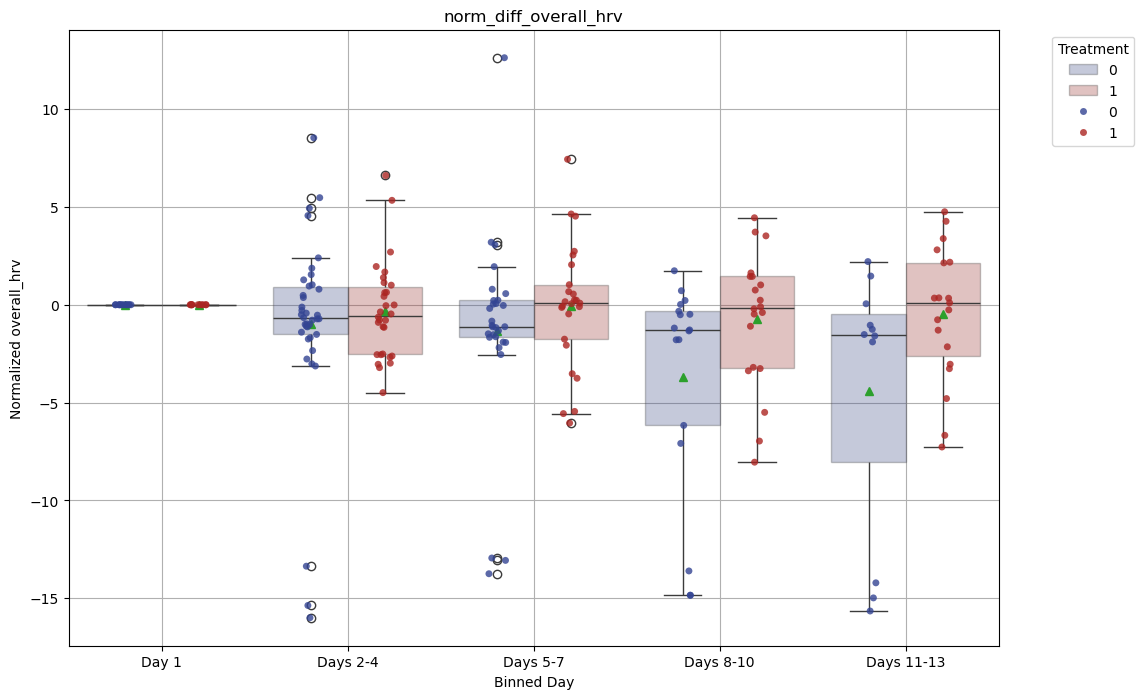

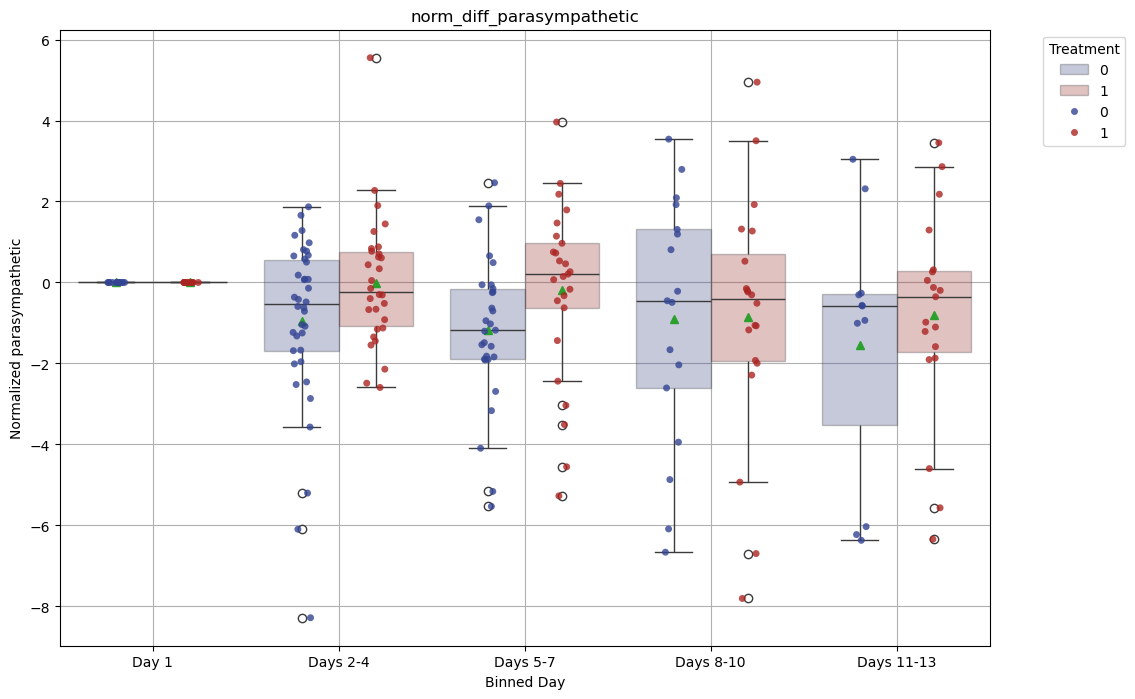

In [11]:
df2plot = df_hrv.copy()
df2plot = df2plot[(df2plot['research_day'] <=13) & (df2plot['research_day'] >=1)]
df2plot['day_bin'] = df2plot['research_day'].apply(assign_3_day_bin)
# set pallete
treatment_color = "#AB2522"
non_treatment_color = "#334493"
hue_order = [0, 1]
palette = {0: non_treatment_color, 1: treatment_color} 
# main script
features_of_interest = ['overall_hrv', 'parasympathetic']
for feature in features_of_interest:
    for subj in df_hrv['subj'].unique():
        baseline = find_valid_baseline(df_hrv, subj, feature)
        if baseline is not None:       
            df_hrv.loc[df_hrv['subj'] == subj, 'norm_diff_' + feature] = \
            df_hrv[df_hrv['subj'] == subj][feature] - baseline
        else:
            pass  
df2plot = df_hrv.copy()
df2plot = df2plot[(df2plot['research_day'] <=13) & (df2plot['research_day'] >=1)]
df2plot['day_bin'] = df2plot['research_day'].apply(assign_3_day_bin)            
for feature in features_of_interest:
    plt.figure(figsize=(12, 8))
    norm_type = 'norm_diff_'
    sns.boxplot(x='day_bin', y=f'{norm_type}{feature}', hue='treatment', data=df2plot,
                palette=palette, showmeans=True, boxprops=dict(alpha=.3))
    sns.stripplot(x='day_bin', y=f'{norm_type}{feature}', hue='treatment', data=df2plot,
                  hue_order=hue_order, palette=palette, dodge=True, jitter=True, alpha=0.8)
    plt.title(f'{norm_type}{feature}')
    plt.xlabel('Binned Day')
    plt.ylabel('Normalized ' + feature)
    plt.legend(title='Treatment', bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True)
    plt.show()